# import packages

In [1]:
import pandas as pd
import dask.dataframe as dd
import numpy as np
import json
from time import time

from collections import Counter

from konlpy.corpus import kolaw
from konlpy.tag import Hannanum
from konlpy.utils import concordance, pprint
import matplotlib.pyplot as plt
from matplotlib import pyplot

from konlpy.tag import *
from gensim.models.word2vec import Word2Vec

km = Komoran()
tw = Twitter()
han = Hannanum()
kkma = Kkma()

def draw_zipf(count_list, filename, color='blue', marker='o'):
    sorted_list = sorted(count_list, reverse=True)
    plt.plot(sorted_list, color=color, marker=marker)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
    #pyplot.savefig(filename)


C:\Anaconda2\envs\py36\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# 나무위키

In [2]:
with open('C:/Users/boogi/Downloads/namuwiki_20180326.json') as f:
    data = json.load(f)

In [3]:
data[0]

{'contributors': ['namubot', 'R:hoon12560'],
 'namespace': '0',
 'text': '#redirect 느낌표\n',
 'title': '!'}

In [4]:
'''
import dask.bag as db
js = db.read_text('C:/Users/boogi/Downloads/namuwiki_1.json').map(json.loads)
js.take(1)
del js
'''

"\nimport dask.bag as db\njs = db.read_text('C:/Users/boogi/Downloads/namuwiki_1.json').map(json.loads)\njs.take(1)\ndel js\n"

In [5]:
len(data)

565985

In [3]:
keys = ['카지노', '호텔', '도박장']
minimal = ''
for i in range(len(data)):
    txt = '%s' % data[i]
    if any([True if key in txt else False for key in keys]):
        for item in txt.split('\\n'):
            if any([True if key in item else False for key in keys]):
                for jtem in item.split('.'):
                    if any([True if key in jtem else False for key in keys]):
                        minimal += jtem + '. '

In [4]:
len(minimal.split('.'))

25508

In [5]:
del data

In [6]:
minimal = minimal.replace(']', '').replace('[', '').replace('*', '').replace('|', '').replace("\\'", "").replace('~', '')

# RNN test

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.optimizers import *
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

from nltk.tokenize import sent_tokenize
#from konlpy.corpus import kolaw
#from konlpy.tag import Twitter

Using TensorFlow backend.


In [8]:
doc0 = [" ".join(["".join(w) for w, t in tw.pos(s) 
                  if (t not in ["Foreign"])]) for s in sent_tokenize(minimal) if (s.count(' ') > 4) & (s.count(' ') < 13)]
doc0 = [item for item in doc0 if item]

In [9]:
len(doc0)

9516

In [34]:
doc0 = [" ".join(["".join(w) for w, t in tw.pos(s) 
                  if (t not in ["Foreign"])]) for s in sent_tokenize(minimal)]

In [35]:
len(doc0)

26296

In [11]:
'''doc0 = [" ".join(["".join(w) for w, t in tw.pos(s) 
                  if t not in ['Number',"Foreign"]]) for s in sent_tokenize(minimal)]'''

In [10]:
tokenizer = Tokenizer()
doc_temp = doc0[:5000]
tokenizer.fit_on_texts(doc_temp)
doc = [l for l in tokenizer.texts_to_sequences(doc_temp) if len(l) > 1]

maxlen = max([len(x) - 1 for x in doc])
vocab_size = len(tokenizer.word_index) + 1

In [11]:
maxlen, vocab_size

(52, 13541)

In [12]:
def generate_data(X, maxlen, vocab_size):
    for sentence in X: 
        inputs = []
        targets = []
        for i in range(1, len(sentence)):
            inputs.append(sentence[0:i])
            targets.append(sentence[i])
        y = np_utils.to_categorical(targets, vocab_size)
        inputs_sequence = sequence.pad_sequences(inputs, maxlen=maxlen)
        yield (inputs_sequence, y)

In [13]:
X = []
Y = []
for x, y in generate_data(doc, maxlen, vocab_size):
    X.append(x)
    Y.append(y)

X = np.concatenate(X)
Y = np.concatenate(Y)

print(X.shape, Y.shape)

(78151, 52) (78151, 13541)


In [14]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=maxlen))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(vocab_size, activation='softmax'))

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 52, 100)           1354100   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 13541)             1367641   
Total params: 2,802,141
Trainable params: 2,802,141
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=["accuracy"])

In [20]:
%%time
hist = model.fit(X, Y, epochs=500, batch_size=800, verbose=2)

Epoch 1/500
19s - loss: 3.7149 - acc: 0.5484
Epoch 2/500
19s - loss: 3.7091 - acc: 0.5494
Epoch 3/500
19s - loss: 3.7067 - acc: 0.5486
Epoch 4/500
19s - loss: 3.7053 - acc: 0.5503
Epoch 5/500
18s - loss: 3.7087 - acc: 0.5483
Epoch 6/500
18s - loss: 3.7080 - acc: 0.5475
Epoch 7/500
19s - loss: 3.7010 - acc: 0.5492
Epoch 8/500
19s - loss: 3.6993 - acc: 0.5499
Epoch 9/500
19s - loss: 3.7070 - acc: 0.5485
Epoch 10/500
19s - loss: 3.6980 - acc: 0.5510
Epoch 11/500
19s - loss: 3.6959 - acc: 0.5507
Epoch 12/500
19s - loss: 3.6946 - acc: 0.5511
Epoch 13/500
19s - loss: 3.6952 - acc: 0.5512
Epoch 14/500
19s - loss: 3.6913 - acc: 0.5506
Epoch 15/500
19s - loss: 3.6934 - acc: 0.5524
Epoch 16/500
19s - loss: 3.6884 - acc: 0.5521
Epoch 17/500
19s - loss: 3.6895 - acc: 0.5525
Epoch 18/500
19s - loss: 3.6886 - acc: 0.5516
Epoch 19/500
19s - loss: 3.6891 - acc: 0.5521
Epoch 20/500
19s - loss: 3.6857 - acc: 0.5518
Epoch 21/500
18s - loss: 3.6840 - acc: 0.5529
Epoch 22/500
19s - loss: 3.6847 - acc: 0.55

19s - loss: 3.5390 - acc: 0.5744
Epoch 179/500
19s - loss: 3.5416 - acc: 0.5745
Epoch 180/500
19s - loss: 3.5338 - acc: 0.5762
Epoch 181/500
19s - loss: 3.5391 - acc: 0.5761
Epoch 182/500
19s - loss: 3.5342 - acc: 0.5763
Epoch 183/500
18s - loss: 3.5398 - acc: 0.5753
Epoch 184/500
19s - loss: 3.5378 - acc: 0.5748
Epoch 185/500
19s - loss: 3.5380 - acc: 0.5742
Epoch 186/500
19s - loss: 3.5315 - acc: 0.5753
Epoch 187/500
19s - loss: 3.5348 - acc: 0.5752
Epoch 188/500
19s - loss: 3.5380 - acc: 0.5752
Epoch 189/500
19s - loss: 3.5327 - acc: 0.5766
Epoch 190/500
19s - loss: 3.5343 - acc: 0.5750
Epoch 191/500
19s - loss: 3.5295 - acc: 0.5775
Epoch 192/500
18s - loss: 3.5332 - acc: 0.5746
Epoch 193/500
19s - loss: 3.5325 - acc: 0.5759
Epoch 194/500
19s - loss: 3.5323 - acc: 0.5738
Epoch 195/500
18s - loss: 3.5258 - acc: 0.5767
Epoch 196/500
18s - loss: 3.5294 - acc: 0.5758
Epoch 197/500
19s - loss: 3.5301 - acc: 0.5762
Epoch 198/500
20s - loss: 3.5261 - acc: 0.5761
Epoch 199/500
21s - loss: 3

18s - loss: 3.4573 - acc: 0.5873
Epoch 354/500
19s - loss: 3.4508 - acc: 0.5871
Epoch 355/500
19s - loss: 3.4533 - acc: 0.5876
Epoch 356/500
19s - loss: 3.4501 - acc: 0.5878
Epoch 357/500
19s - loss: 3.4496 - acc: 0.5883
Epoch 358/500
19s - loss: 3.4507 - acc: 0.5895
Epoch 359/500
19s - loss: 3.4508 - acc: 0.5890
Epoch 360/500
19s - loss: 3.4509 - acc: 0.5880
Epoch 361/500
19s - loss: 3.4510 - acc: 0.5888
Epoch 362/500
19s - loss: 3.4485 - acc: 0.5886
Epoch 363/500
19s - loss: 3.4508 - acc: 0.5874
Epoch 364/500
19s - loss: 3.4464 - acc: 0.5894
Epoch 365/500
19s - loss: 3.4465 - acc: 0.5893
Epoch 366/500
19s - loss: 3.4473 - acc: 0.5890
Epoch 367/500
19s - loss: 3.4455 - acc: 0.5893
Epoch 368/500
19s - loss: 3.4453 - acc: 0.5892
Epoch 369/500
19s - loss: 3.4444 - acc: 0.5892
Epoch 370/500
19s - loss: 3.4482 - acc: 0.5880
Epoch 371/500
19s - loss: 3.4407 - acc: 0.5906
Epoch 372/500
19s - loss: 3.4408 - acc: 0.5897
Epoch 373/500
19s - loss: 3.4436 - acc: 0.5897
Epoch 374/500
18s - loss: 3

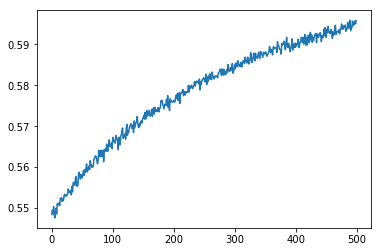

In [30]:
plt.plot(hist.history['acc'])
plt.show()

In [106]:
# h5py 설치를 안해놔서 모델 전체 저장 안됨
model.save("rnn_text_gen.hdf5")

ImportError: `save_model` requires h5py.

In [25]:
# 모델을 json 형식으로 변환
json_string = model.to_json()

In [27]:
# 모델을 json파일로 저장(weight없이)
with open('rnn_test.json', 'w') as f:
    json.dump(json_string, f)

In [112]:
# weights를 numpy array로 저장(.h5형식으로 저장이 안되서)
np.save('weights', np.array(model.get_weights()))

In [100]:
from keras.models import model_from_json

In [86]:
# 저장한 모델 읽기(No weights)
with open('rnn_test.json', 'r') as f:
    json_string = json.load(f)

In [87]:
# json에서 모델 읽기
model2 = model_from_json(json_string)

In [121]:
# numpy array로 저장한 weights를 불러와서 json으로 저장한 모델에 불러오기
a = np.load('weights.npy')
model2.set_weights(list(a))

In [43]:
def generate(w, n, seed=None, model=model):
    
    if seed is not None:
        np.random.seed(seed)
    
    def _predict_word(sent):
        x = sequence.pad_sequences([[tokenizer.word_index[w] for w in sent]], maxlen=maxlen)
        p = model.predict(x)[0]
        logp = np.log(p)
        p = np.exp(logp) / np.sum(np.exp(logp))
        p = p[1:]
        return np.random.choice(list(tokenizer.word_index.keys()), p=p)

    sent = [w]
    for i in range(n):
        w = _predict_word(sent)
        sent.append(w)
        
    return " ".join(sent)

## 문장 생성 테스트(keyword로 시작)

### 그냥 모델만 저장했을 때와 numpy array로 저장한 weights를 적용한 모델 비교

In [123]:
for i in range(10):
    print((generate('가수', 3, model=model3, seed=i)))

가수 실례하지 미현 귀하
가수 현직 시즈오카현 다
가수 부잣집 가는 발품
가수 중화권 유유 룩
가수 능통 성공해 돌아오게
가수 총회 요사 콘크리트
가수 허무 행보 연맹
가수 커피 정한 웨스
가수 윙 입게 an
가수 없다 써클 마포구


In [122]:
for i in range(10):
    print(tw.pos(generate('가수', 3, model=model2, seed=i)))

[('가수', 'Noun'), ('보기', 'Noun'), ('좀비', 'Noun'), ('게', 'Noun')]
[('가수', 'Noun'), ('물', 'Noun'), ('난', 'Noun'), ('호텔', 'Noun')]
[('가수', 'Noun'), ('가게', 'Noun'), ('호텔', 'Noun'), ('을', 'Josa')]
[('가수', 'Noun'), ('은닉', 'Noun'), ('마찬가지', 'Noun'), ('않았', 'Verb')]
[('가수', 'Noun'), ('근원', 'Noun'), ('호텔', 'Noun'), ('bond', 'Alpha')]
[('가수', 'Noun'), ('21', 'Number'), ('라는', 'Josa'), ('이름', 'Noun')]
[('가수', 'Noun'), ('평이', 'Noun'), ('한', 'Verb'), ('주민', 'Noun')]
[('가수', 'Noun'), ('류경', 'Noun'), ('호텔', 'Noun'), ('을', 'Josa')]
[('가수', 'Noun'), ('blog', 'Alpha'), ('빨', 'Noun'), ('린드', 'Noun')]
[('가수', 'Noun'), ('호텔', 'Noun'), ('에', 'Josa'), ('배서', 'Noun')]


C:\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


In [105]:
for i in range(10):
    print((generate('가수', 3, model=model, seed=i)))

가수 보기 좀비 게
가수 물 난 호텔
가수 가게 호텔 을
가수 은닉 마찬가지 않았
가수 근원 호텔 bond
가수 21 라는 이름
가수 평이 한 주민
가수 류경 호텔 을
가수 blog 빨 린드
가수 호텔 에 배서


C:\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


- RNN + 형태소 학습 결합하여 자연스러운 문장 예측 성능 향상
- 왜 저장한 결과와 다르게 나오는지...??? → weights 저장이 안되서 발생한 문제, 해결함.

In [66]:
word_list = doc0[9].split(' ')
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

In [94]:
doc0[9]

'가수 신정환 이 불법 카지노 바 에 있다 가 경찰 에 연행 됨 .'

In [67]:
len(reverse_word_map)

13540

In [70]:
x = sequence.pad_sequences([[tokenizer.word_index[w] for w in word_list[:i]]], maxlen=maxlen)

In [81]:
def predict_word(i, n=1, model=model):
    x = sequence.pad_sequences([[tokenizer.word_index[w] for w in word_list[:i]]], maxlen=maxlen)
    p = model.predict(x)[0]
    idx = np.flip(np.argsort(p), 0)
    for j in idx[:n]:
        print('"', " ".join(word_list[:i]), '"', reverse_word_map[j], " (p={:4.2f}%)".format(100 * p[j]))

In [124]:
predict_word(4, n=3, model=model2)

" 가수 신정환 이 불법 " 카지노  (p=97.24%)
" 가수 신정환 이 불법 " 도박장  (p=0.92%)
" 가수 신정환 이 불법 " 호텔  (p=0.30%)


In [125]:
predict_word(4, n=3, model=model)

" 가수 신정환 이 불법 " 카지노  (p=97.24%)
" 가수 신정환 이 불법 " 도박장  (p=0.92%)
" 가수 신정환 이 불법 " 호텔  (p=0.30%)


## 추가 학습(중도학습)

In [129]:
from keras.callbacks import ModelCheckpoint

In [135]:
%%time
hist = model.fit(X, Y, epochs=30, verbose=2, batch_size=800, callbacks=[ModelCheckpoint('test', monitor='val_loss', save_best_only=True, save_weights_only=True, period=5)])

Epoch 1/30
19s - loss: 3.3808 - acc: 0.5985
Epoch 2/30
19s - loss: 3.3747 - acc: 0.6009
Epoch 3/30
18s - loss: 3.3795 - acc: 0.5994
Epoch 4/30
18s - loss: 3.3836 - acc: 0.5984
Epoch 5/30


C:\Anaconda2\envs\py36\lib\site-packages\keras\callbacks.py:405: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


18s - loss: 3.3813 - acc: 0.5997
Epoch 6/30
19s - loss: 3.3751 - acc: 0.6007
Epoch 7/30
19s - loss: 3.3801 - acc: 0.6004
Epoch 8/30
18s - loss: 3.3816 - acc: 0.5988
Epoch 9/30
18s - loss: 3.3805 - acc: 0.5989
Epoch 10/30
18s - loss: 3.3769 - acc: 0.6000
Epoch 11/30
18s - loss: 3.3771 - acc: 0.5994
Epoch 12/30
18s - loss: 3.3746 - acc: 0.6002
Epoch 13/30
19s - loss: 3.3757 - acc: 0.6007
Epoch 14/30
19s - loss: 3.3778 - acc: 0.5993
Epoch 15/30
19s - loss: 3.3772 - acc: 0.5988
Epoch 16/30
19s - loss: 3.3760 - acc: 0.5991
Epoch 17/30
18s - loss: 3.3776 - acc: 0.5992
Epoch 18/30
18s - loss: 3.3794 - acc: 0.5989
Epoch 19/30
18s - loss: 3.3761 - acc: 0.5996
Epoch 20/30
19s - loss: 3.3777 - acc: 0.6005
Epoch 21/30
18s - loss: 3.3763 - acc: 0.5999
Epoch 22/30
19s - loss: 3.3717 - acc: 0.6001
Epoch 23/30
19s - loss: 3.3776 - acc: 0.5989
Epoch 24/30
18s - loss: 3.3784 - acc: 0.6002
Epoch 25/30
18s - loss: 3.3732 - acc: 0.6001
Epoch 26/30
18s - loss: 3.3756 - acc: 0.6003
Epoch 27/30
18s - loss: 3.

In [146]:
(model.get_weights()[0]).max()

2.5194573

In [153]:
np.random.randn(1, 2)

array([[1.82281576, 0.43076903]])

In [155]:
def mutation(w):
    w[0] += 0.01 * (np.random.randn(w[0].shape[0], w[0].shape[1]) * (w[0].max() - w[0].min()) + w[0].min())
    w[1] += 0.01 * (np.random.randn(w[1].shape[0], w[1].shape[1]) * (w[1].max() - w[1].min()) + w[1].min())
    return w

In [156]:
mutation(model.get_weights())

[array([[ 0.7351876 , -0.43644047, -0.36678466, ..., -0.01549795,
         -0.06438367, -0.4471951 ],
        [ 0.3025028 , -0.6211122 , -1.1915572 , ...,  0.01153985,
          0.8751277 , -0.10665391],
        [ 0.63592654,  0.4260004 , -0.19596328, ..., -0.68603945,
         -0.8406526 , -0.20035352],
        ...,
        [-0.432057  , -0.57735807,  0.27669528, ..., -0.55574524,
         -0.34016576,  0.3945297 ],
        [-0.13053454, -0.63100976,  0.28007406, ..., -0.11714929,
         -0.77756345, -0.23766026],
        [-0.62980527,  1.021756  ,  0.43972573, ..., -0.6539217 ,
          0.27806056, -0.08430402]], dtype=float32),
 array([[ 0.24221294, -1.108445  , -2.5021355 , ..., -2.547346  ,
         -0.88051176, -1.8978034 ],
        [-2.3554056 , -0.48075435, -1.5774957 , ...,  0.74631196,
          0.7555562 , -0.3369536 ],
        [-1.7833067 , -0.15871213, -1.0864877 , ..., -1.7521857 ,
         -2.7291863 , -0.1587568 ],
        ...,
        [-0.62557185, -0.68355954, -1.1

In [157]:
%%time
b = model.get_weights()
b = mutation(b)
model.set_weights(b)
hist = model.fit(X, Y, epochs=30, verbose=2, batch_size=800, callbacks=[ModelCheckpoint('test', monitor='val_loss', save_best_only=True, save_weights_only=True, period=5)])

Epoch 1/30
19s - loss: 9.8345 - acc: 0.0173
Epoch 2/30
18s - loss: 8.5956 - acc: 0.0297
Epoch 3/30
19s - loss: 8.1221 - acc: 0.0404
Epoch 4/30
18s - loss: 7.7944 - acc: 0.0521
Epoch 5/30


C:\Anaconda2\envs\py36\lib\site-packages\keras\callbacks.py:405: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


18s - loss: 7.5744 - acc: 0.0649
Epoch 6/30


KeyboardInterrupt: 

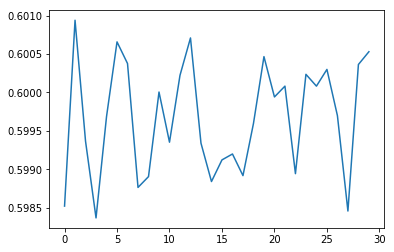

In [136]:
plt.plot(hist.history['acc'])
plt.show()

In [137]:
a = model.get_weights()
np.save('weights2', np.array(a))

In [138]:
for i in range(10):
    print(generate('가수', 10, seed=i, model=model))

가수 번호 가 추가되 었 지만 무료 다르 호텔 감소한 다
가수 형태 도 호텔 방 을 로 하고 있 범죄 주거
가수 가게 호텔 을 지는 하기 도 남자 는 http 출입
가수 코엑스 한 며 가 리스 호텔 로 버스 개 음
가수 총리 가 쓴 헬 머신 에 부담하겠 을 전부 바깥
가수 2016 인 출구 서머 둔 전망대 에 고속 인수 호텔
가수 판다 가 만원 이 월 롯데 호텔 에 대한민국 전
가수 다른 호텔 이 침입 한 테러리스트 장식 이 테마 파크
가수 렉스 전개하고 있다 고 숙박 이 난 어머니 는 수도
가수 호텔 이 6549 에서 못 가격 있다 는 후 를


# 국문 example

In [ ]:
# 국문
def korean_most_common(c, n, pos=None):
    bg = bigram
    if pos is None:
        return bigram[tokenize(c)[0]].most_common(n)
    else:
        return bigram["/".join([c, pos])].most_common(n)
    
def korean_generate_sentence(seed=None, debug=False):
    if seed is not None:
        np.random.seed(seed)
    c = "SS"
    sentence = []
    while True:
        if c not in bigram:
            break
        words, probs = zip(*[(k, v) for k, v in bigram[c].items()])
        idx = np.argmax(np.random.multinomial(1, probs, (1,)))
        w = words[idx]
        
        if w == "SE":
            break            
        
        w2 = w.split("/")[0]
        pos = w.split("/")[1]
        
        if c == "SS":
            sentence.append(w2.title())
        elif c in ["`", "\"", "'", "("]:
            sentence.append(w2)
        elif w2 in ["'", ".", ",", ")", ":", ";", "?"]:
            sentence.append(w2)
        elif pos in ["Josa", "Punctuation", "Suffix"]:
            sentence.append(w2)
        elif w in ["임/Noun", "것/Noun", "는걸/Noun", "릴때/Noun",
                   "되다/Verb", "이다/Verb", "하다/Verb", "이다/Adjective"]:
            sentence.append(w2)
        else:
            sentence.append(" " + w2)
        c = w
        
        if debug:
            print(w)
            
    return "".join(sentence)